<a href="https://colab.research.google.com/github/C1PO/Machine_learning/blob/main/cognition%26computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# carica il dataset CIFAR-10
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
x_val = x_val / 255.


In [ ]:
from keras.utils import to_categorical, plot_model

# converti le etichette di training in formato one-hot encoding
y_train = to_categorical(y_train, num_classes=10)

# converti le etichette di test in formato one-hot encoding
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

#IL RESHAPE QUA NON VIENE FATTO PERO LA SHAPE SEMBRA VADA BENE LO STESSO (?)

In [ ]:
x_train.shape

(40000, 32, 32, 3)

In [ ]:
print("The number of samples of the training set is", x_train.shape[0])
print("The number of samples of the test set is", x_test.shape[0])

The number of samples of the training set is 40000
The number of samples of the test set is 10000


In [ ]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

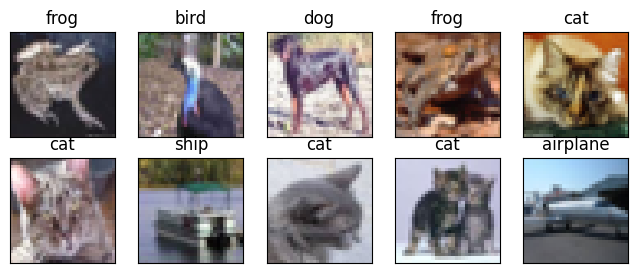

In [ ]:
# plotting the first 10 images of the training set
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])
    ax.set_title(labels[np.argmax(y_train[i])])
plt.show()

In [ ]:
print(x_train.shape)
print(y_train.shape)

(40000, 32, 32, 3)
(40000, 10)


## Define the model

In [ ]:
from os import name
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, AveragePooling2D, Input, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

weight_decay = 1e-4

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], name='conv1'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', name='conv3'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', name='conv5'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv6'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu', name='dense1'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name='dense2'))


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0000001)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 1.6402 - accuracy: 0.4177

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
def plot_accuracy(history):
  plt.figure(figsize=(8,5))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.show()

In [ ]:
plot_accuracy(history)

In [ ]:
def plot_errors(history):
  plt.figure(figsize=(8,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
plot_errors(history)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff

y_pred = model.predict(x_test)

# converte le etichette di classe dal formato one-hot encoding a formato interi
y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# calcola l'accuratezza e la matrice di confusione
cm = confusion_matrix(y_test_int, y_pred_int)

fig = ff.create_annotated_heatmap(z=np.array(cm), colorscale='Blues')
fig.update_layout(title='Confusion Matrix')
fig.show()

## Linear read out

In [ ]:
from tensorflow.keras.models import Model

def get_hidden_representation(layer_name):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(x_train)
    return intermediate_output

In [ ]:
conv5_output = get_hidden_representation('conv5')
conv6_output = get_hidden_representation('conv6')
dense1_output = get_hidden_representation('dense1')

In [ ]:
conv5_output.shape

In [ ]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(8, 8, 32)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# compila il modello
linear_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_conv5 = linear_model.fit(conv5_output, y_train,
                batch_size=64,
                epochs=20,
                validation_split=0.2)
#se metto validatio_data=(x_val, y_val) --> mi da errore. perchè?

In [ ]:
linear_model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(8, 8, 32)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# compila il modello
linear_model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_conv6 = linear_model2.fit(conv6_output, y_train,
                batch_size=64,
                epochs=20,
                validation_split=0.2)

In [ ]:
linear_model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1024,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# compila il modello
linear_model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_dense1 = linear_model3.fit(dense1_output, y_train,
                batch_size=64,
                epochs=20,
                validation_split=0.2)

In [ ]:
#perche sull'evaluate mettiamo y_train e non test?
score_conv5 = linear_model.evaluate(conv5_output, y_train, verbose=0)
print('Test accuracy of the linear model with conv5 input:', score_conv5[1])

In [ ]:
plot_accuracy(history_conv5)
plot_errors(history_conv5)

In [ ]:
score_conv6 = linear_model2.evaluate(conv6_output, y_train, verbose=0)
print('Test accuracy of the linear model with conv6 input:', score_conv6[1])

In [ ]:
plot_accuracy(history_conv6)
plot_errors(history_conv6)

In [ ]:
score_dense1 = linear_model3.evaluate(dense1_output, y_train, verbose=0)
print('Test accuracy of the linear model with dense input:', score_dense1[1])

In [ ]:
plot_accuracy(history_dense1)
plot_errors(history_dense1)

## Features visualization

In [ ]:
plt.imshow(x_train[0])
plt.show()

In [ ]:
!pip install keract
from keract import get_activations, display_activations

layer_names=['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'dense1', 'dense2']
# ottieni le attivazioni del primo esempio di train
activations_cnn = get_activations(model, x_train[0:1], layer_names=layer_names)

# mostra le attivazioni
display_activations(activations_cnn, cmap="viridis")


## Robustness to Gaussian noise

In [ ]:
print('Accuracy prima dell\'aggiunta di rumore: {:.2f}%'.format(test_acc * 100))

noise_factor = 0.2
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)


noise_loss, noise_acc = model.evaluate(x_test_noisy, y_test, verbose=0)
print('Accuracy dopo l\'aggiunta di rumore: {:.2f}%'.format(noise_acc * 100))

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
len(labels)

In [ ]:
plt.imshow(x_test[0])
plt.show()
plt.imshow(x_test_noisy[0],cmap = 'viridis',interpolation = "nearest")
plt.show()
print("label originale", labels[np.argmax(y_test[0])])
print("label dopo noise", labels[np.argmax(y_pred_noisy[0])])
print("label predetta dal modello originale", labels[np.argmax(y_pred[0])])

## Adversarial Attack

In [ ]:
# Definisci la funzione per generare gli attacchi adversariali con il Fast Gradient Sign Method
def generate_adversarial_example(input_image, input_label, epsilon):
    # Imposta i gradienti calcolati sulla variabile di input
    input_image = tf.cast(input_image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)

    # Calcola i gradienti rispetto all'input
    gradient = tape.gradient(loss, input_image)

    # Applica il segno al gradiente e normalizzalo
    signed_grad = tf.sign(gradient)
    perturbation = epsilon * signed_grad

    # Applica la perturbazione all'immagine originale
    perturbed_image = input_image + perturbation
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)

    return perturbed_image

In [ ]:
def plot_adversarial_image(x_adv):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(x.squeeze(), cmap='viridis')
  axs[0].set_title('Original Example')
  axs[1].imshow(x_adv.numpy().squeeze(), cmap='viridis')
  axs[1].set_title('Adversarial Example')
  plt.show()

  y_pred = model.predict(x)
  y_pred_adv = model.predict(x_adv)

  print('True Label:', labels[y_true])
  print('Predicted label:', labels[np.argmax(y_pred)])
  print('Predicted label after adversarial attack:', labels[np.argmax(y_pred_adv)])


In [ ]:
plt.imshow(x_test[0])
plt.show()

In [ ]:
x = x_test[0]
x = x.reshape(1, 32, 32, 3)
y_true = np.argmax(y_test[0])
epsilons = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.07,0.08,0.09]

for i in epsilons:
  x_adv = generate_adversarial_example(x, y_true, i)
  print("Epsilon: ",i)
  plot_adversarial_image(x_adv)

## autoencoder

In [ ]:
#Function to create an autoencoder
def create_model():
  input_image = tf.keras.Input(shape=(32, 32, 3))

  #Encoding phase
  x = Conv2D(32, 3, activation='relu', padding='same', name='encoder_first_conv')(input_image)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, 3, activation='relu', padding='same', name='encoder_second_conv')(x)
  encoded = MaxPooling2D(2, padding='same')(x)
  print(encoded.shape)

  #Decoding phase
  x = Conv2D(16, 3, activation='relu', padding='same',name='decoder_first_conv')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, 3, activation='relu', padding='same',name='decoder_second_conv')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='last_conv')(x)
  autoencoder = tf.keras.Model(input_image, decoded)
  autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
  return autoencoder

autoencoder_layer_names = ['encoder_first_conv','encoder_second_conv','decoder_first_conv','decoder_second_conv','last_conv']

In [ ]:
autoencoder = create_model()

In [ ]:
noise_level = 0.1

#Insert noise in the training set
x_train_noisy = x_train + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

#Insert noise in the validation set
x_val_noisy = x_val + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

#Force the pixel value to be between 0 and 1
X_train_noisy = np.clip(x_train_noisy, 0., 1.)
X_validation_noisy = np.clip(x_val_noisy, 0., 1.)
     

In [ ]:
autoencoder_results=autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=False,
                validation_data=(x_val_noisy, x_val)
                )

In [ ]:
 #Store the loss of the training and validation set
training_loss = autoencoder_results.history['loss']
validation_loss = autoencoder_results.history['val_loss']

#Loss history for training and validation
plt.figure(figsize=(10, 8))
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Autoencoder: Absolute Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()